In [40]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pprint import pprint

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_circles

import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable
from livelossplot import PlotLosses

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
input_size = 2         # Input data dimensionality
hidden_size = 3        # The number of nodes at the hidden layer
num_classes = 2        # The number of output classes
num_epochs = 20        # The number of times entire dataset is trained
batch_size = 20        # The size of input data for one iteration
learning_rate = 0.01   # The speed of convergence

In [41]:
print(torch.__version__)
print(torch.cuda.is_available())

1.7.1+cu110
True


In [42]:
# dataset params
N = 50000
factor = 0.1
noise = 0.1

# generate data
X, y = make_circles(n_samples=N, shuffle=False, factor=factor, noise=noise)

X_tensor = torch.from_numpy(X) # add code "torch.from_numpy(X).cuda()" to use GPU
y_tensor = torch.from_numpy(y)
X_tensor.shape, y_tensor.shape

dataset = utils.TensorDataset(X_tensor,y_tensor)

dataloader = utils.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [43]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()                    # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.logistic = nn.LogSigmoid()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        """Forward pass: stacking each layer together"""
        out = self.fc1(x)
        out = self.logistic(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

net = Net(input_size, hidden_size, num_classes)
net

Net(
  (fc1): Linear(in_features=2, out_features=3, bias=True)
  (logistic): LogSigmoid()
  (fc2): Linear(in_features=3, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [44]:
pprint(list(net.parameters()))

[Parameter containing:
tensor([[-0.0155,  0.4762],
        [-0.0752,  0.3967],
        [-0.1758,  0.0739]], requires_grad=True),
 Parameter containing:
tensor([-0.1363, -0.4561,  0.5176], requires_grad=True),
 Parameter containing:
tensor([[ 0.3984, -0.1271, -0.4911],
        [-0.2601, -0.5482, -0.2975]], requires_grad=True),
 Parameter containing:
tensor([0.1074, 0.3764], requires_grad=True)]


In [45]:
list(net.parameters())[0]

Parameter containing:
tensor([[-0.0155,  0.4762],
        [-0.0752,  0.3967],
        [-0.1758,  0.0739]], requires_grad=True)

In [46]:
# Enable GPU
# net.cuda()

# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Select Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Train Model
for epoch in range(num_epochs):
    print(epoch)
    for i, (features, label) in enumerate(dataloader):
        features = Variable(features.float())
        label = Variable(label.long())

        # Initialize the hidden weights
        optimizer.zero_grad()

        # Forward pass: compute output given features
        outputs = net(features)

        # Compute the loss
        loss = criterion(outputs, label)
        # Backward pass: compute the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


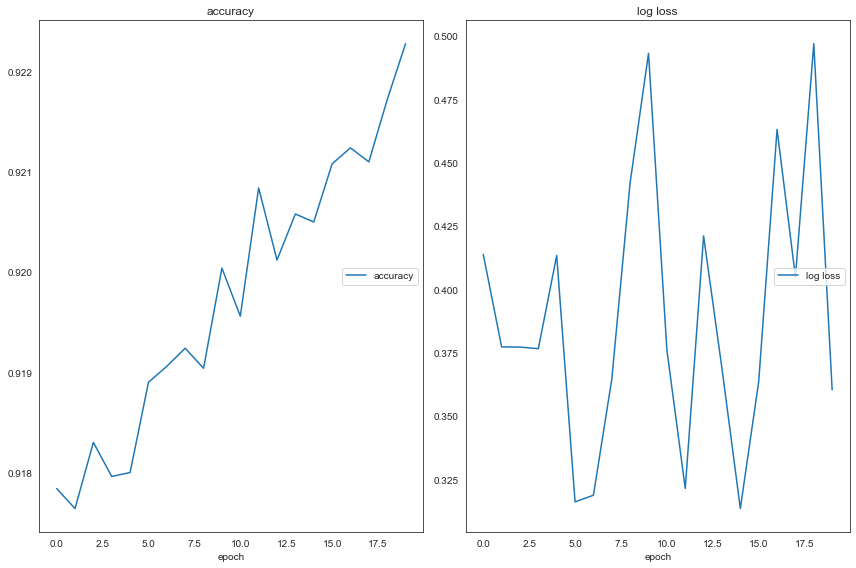

accuracy
	accuracy         	 (min:    0.918, max:    0.922, cur:    0.922)
log loss
	log loss         	 (min:    0.313, max:    0.497, cur:    0.360)


In [47]:
# Plotting losses in real time
liveloss = PlotLosses()
for epoch in range(num_epochs):
    print(epoch)
    logs = {}
    running_loss = 0.0
    running_corrects = 0
    for i, (features, label) in enumerate(dataloader):

        features = Variable(features.float())
        label = Variable(label.long())

        # Intialize the hidden weight to all zeros
        optimizer.zero_grad()

        # Forward pass: compute the output class given a image
        outputs = net(features)

        # Compute the loss: difference between the output class and the pre-given label
        loss = criterion(outputs, label)
        # Backward pass: compute the weight
        loss.backward()
        # Optimizer: update the weights of hidden nodes
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.detach() * features.size(0)
        running_corrects += torch.sum(preds == label.data)

        epoch_loss = running_loss / len(dataset)
        epoch_acc = running_corrects.float() / len(dataloader.dataset)
        logs['log loss'] = loss.item()
        logs['accuracy'] = epoch_acc.item()

    liveloss.update(logs)
    liveloss.draw()

In [48]:
# Predict
test_value = Variable(torch.from_numpy(X)).float()
prediction = net(test_value).data.numpy()
prediction.shape

(50000, 2)

In [49]:
# Score Prediction
accuracy_score(y_true=y, y_pred=np.argmax(prediction, axis=1))

0.92202

In [50]:
# Visualize Decision Boundary
n_vals = 200
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  # create the grid
X_test = np.array([xx.ravel(), yy.ravel()]).T
X_test = torch.from_numpy(X_test)
X_test.shape

torch.Size([40000, 2])

In [51]:
# Predict Feature Space
zz = net(Variable(X_test).float()).data.numpy()
zz.shape

(40000, 2)

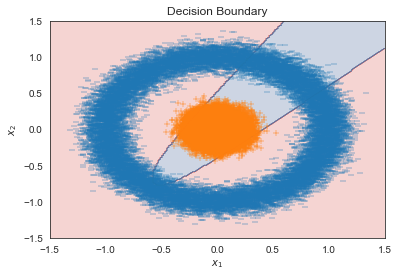

In [52]:
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]])

# Plot Decision Boundary
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, np.argmax(zz, axis=1).reshape(n_vals, -1), cmap=cmap, alpha=.25)

# Plot both classes on the x1, x2 plane
data = pd.DataFrame(X, columns=['$x_1$', '$x_2$']).assign(Class=pd.Series(y).map({0:'negative', 1:'positive'}))
sns.scatterplot(x='$x_1$', y='$x_2$', hue='Class', data=data, style=y, markers=['_', '+'], legend=False)
plt.title('Decision Boundary');